Jane Downer<br>
CS 577-02 - Fall 2022<br>
Assignment 2<br>

In [ ]:
ROOT_PATH = '/content/drive/MyDrive/2022 files/CS 577/Assignments/hw2'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import time
import pandas as pd
import numpy as np
import math
import tensorflow
import keras
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.metrics import Mean as mean_tracker
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.losses import categorical_crossentropy
from keras.metrics import CategoricalAccuracy
from keras import models, layers
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [ ]:
os.chdir(ROOT_PATH)

# Question 1

In [ ]:
def load_data(data, test_p=0.2, label_column_idx=-1):
    categories = data.columns[label_column_idx]
    labels = list(L for L in list(data[categories]))
    three_labels = list(set(labels))[:3]
    data = data[data[categories].isin(three_labels)]

    labels = data.pop(categories)
    n_train = int((1-test_p)*len(data))
    X_trn, X_tst = np.array(data[:n_train]), np.array(data[n_train:])
    
    y_trn, y_tst = np.array(labels[:n_train]), np.array(labels[n_train:])

    y_trn_c = OneHotEncoder(sparse=False).fit_transform(y_trn.reshape(-1,1))
    y_tst_c = OneHotEncoder(sparse=False).fit_transform(y_tst.reshape(-1,1))

    mean_data = np.concatenate([X_trn,X_tst]).mean(axis=0)
    std_data = np.concatenate([X_trn,X_tst]).std(axis=0)

    X_trn = (X_trn - mean_data)/std_data
    X_tst = (X_tst - mean_data)/std_data

    return (X_trn, y_trn_c), (X_tst, y_tst_c)

In [ ]:
url_wine = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data_wine = pd.read_csv(url_wine, delimiter=';', delim_whitespace=False)
data_wine = data_wine.sample(frac=1).reset_index(drop=True)
(X_trn_wine, y_trn_wine), (X_tst_wine, y_tst_wine) = load_data(data_wine)

url_bean = 'http://archive.ics.uci.edu/ml/datasets/Dry+Bean+Dataset#:~:text=Set%0ADownload%3A-,Data%20Folder,-%2C%20Data%20Set'
#!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00602/DryBeanDataset.zip
#!unzip "/content/drive/MyDrive/2022 files/CS 577/Assignments/hw2/DryBeanDataset.zip"
data_bean = pd.read_excel('/content/drive/MyDrive/2022 files/CS 577/Assignments/hw2/DryBeanDataset/Dry_Bean_Dataset.xlsx')
data_bean = data_bean.sample(frac=1).reset_index(drop=True)
(X_trn_bean, y_trn_bean), (X_tst_bean, y_tst_bean) = load_data(data_bean)

In [ ]:
def build_model(X_trn, input_size_L1, input_size_L2):
    inputs  = keras.Input(shape=(X_trn.shape[1]))
    L_h1    = layers.Dense(input_size_L1, activation='sigmoid')(inputs)
    L_h2    = layers.Dense(input_size_L2, activation='sigmoid')(L_h1)
    outputs = layers.Dense(3,   activation='softmax')(L_h2)
    return keras.Model(inputs, outputs)

class BatchGenerator:
    def __init__(self, X_trn, y_trn, batch_size):
        assert len(X_trn) == len(y_trn)
        self.index = 0
        self.X_trn = X_trn
        self.y_trn = y_trn
        self.batch_size = batch_size
        self.num_batches = math.ceil(len(X_trn)/batch_size)
    def next(self):
        X_trn = self.X_trn[self.index : self.index + self.batch_size] 
        y_trn = self.y_trn[self.index : self.index + self.batch_size] 
        self.index += self.batch_size
        return X_trn, y_trn

def train_step(model, X_batch, y_batch, optimizer, loss_tracker, acc_tracker):
    with tensorflow.GradientTape() as tape:
        pred     = model(X_batch)
        loss     = categorical_crossentropy(y_batch, pred)
        acc      = categorical_accuracy(y_batch, pred)
        avg_loss = tensorflow.reduce_mean(loss)
        avg_acc  = tensorflow.reduce_mean(acc)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    loss_tracker.update_state(avg_loss) 
    acc_tracker.update_state(avg_acc)
    logs = {'train_loss': loss_tracker.result().numpy(), 
            'train_acc':  acc_tracker.result().numpy()}
    return logs

def val_step(model, X_val_batch, y_val_batch, val_loss_tracker, val_acc_tracker):
    val_pred     = model(X_val_batch)
    val_loss     = categorical_crossentropy(y_val_batch, val_pred)
    val_acc      = categorical_accuracy(y_val_batch, val_pred)
    val_avg_loss = tensorflow.reduce_mean(val_loss)
    val_avg_acc  = tensorflow.reduce_mean(val_acc)
    val_loss_tracker.update_state(val_avg_loss) 
    val_acc_tracker.update_state(val_avg_acc)
    logs = {'val_loss': val_loss_tracker.result().numpy(), 
            'val_acc': val_acc_tracker.result().numpy()}
    return logs

def fit(model, X_trn, y_trn, epochs, batch_size, optimizer, loss_tracker, acc_tracker, val_loss_tracker, val_acc_tracker):
    X_trn, X_val, y_trn, y_val = train_test_split(X_trn, y_trn, test_size=0.2)
    train_loss, train_acc, val_loss, val_acc = [], [], [], []
    print('train:',X_trn.shape)
    print('val:',X_val.shape)
    for epoch in range(epochs):
        loss_tracker.reset_state()
        acc_tracker.reset_state()

        train_batch_generator = BatchGenerator(X_trn, y_trn, batch_size)
        for batch in range(train_batch_generator.num_batches):
            X_batch, y_batch = train_batch_generator.next()
            train_metrics = train_step(model, X_batch, y_batch, optimizer, loss_tracker, acc_tracker)
        t_loss = train_metrics['train_loss']
        t_acc  = train_metrics['train_acc']
        train_loss.append(t_loss)
        train_acc.append(t_acc)

        val_batch_generator = BatchGenerator(X_val, y_val, batch_size)
        for batch in range(val_batch_generator.num_batches):
            val_X_batch, val_y_batch = val_batch_generator.next()
            test_metrics = val_step(model, val_X_batch, val_y_batch, val_loss_tracker, val_acc_tracker)
        v_loss = test_metrics['val_loss']
        v_acc  = test_metrics['val_acc']
        val_loss.append(v_loss)
        val_acc.append(v_acc)

        if epoch%10 == 0:
            print(f'Epoch {epoch}/{epochs}  '.ljust(24)
                +    'train_loss: ' + "{:.3f}".format(t_loss) 
                + ' , val_loss: '   + "{:.3f}".format(v_loss)
                + ' , train_acc: '  + "{:.3f}".format(t_acc)
                + ' , val_acc: '    + "{:.3f}".format(v_acc))
        
    return model, train_loss, train_acc, val_loss, val_acc

In [ ]:
bean_model = build_model(X_trn_bean, 32, 16)
model_bean, tr_loss_bean, tr_acc_bean, v_loss_bean, v_acc_bean = fit(
    bean_model, 
    X_trn_bean, 
    y_trn_bean, 
    epochs=200,
    batch_size=512,
    optimizer = optimizers.Adam(learning_rate=0.001),
    loss_tracker = mean_tracker(name='train_loss'),
    acc_tracker  = mean_tracker(name='train_acc'),
    val_loss_tracker = mean_tracker(name='val_loss'),
    val_acc_tracker  = mean_tracker(name='val_acc'))

train: (4348, 16)
val: (1088, 16)
Epoch 0/200             train_loss: 1.645 , val_loss: 1.510 , train_acc: 0.281 , val_acc: 0.288
Epoch 10/200            train_loss: 0.751 , val_loss: 1.018 , train_acc: 0.769 , val_acc: 0.545
Epoch 20/200            train_loss: 0.436 , val_loss: 0.802 , train_acc: 0.969 , val_acc: 0.722
Epoch 30/200            train_loss: 0.250 , val_loss: 0.646 , train_acc: 0.986 , val_acc: 0.806
Epoch 40/200            train_loss: 0.160 , val_loss: 0.535 , train_acc: 0.987 , val_acc: 0.849
Epoch 50/200            train_loss: 0.115 , val_loss: 0.456 , train_acc: 0.989 , val_acc: 0.876
Epoch 60/200            train_loss: 0.090 , val_loss: 0.398 , train_acc: 0.989 , val_acc: 0.894
Epoch 70/200            train_loss: 0.074 , val_loss: 0.353 , train_acc: 0.990 , val_acc: 0.907
Epoch 80/200            train_loss: 0.064 , val_loss: 0.318 , train_acc: 0.990 , val_acc: 0.917
Epoch 90/200            train_loss: 0.057 , val_loss: 0.289 , train_acc: 0.990 , val_acc: 0.925
Epoch 

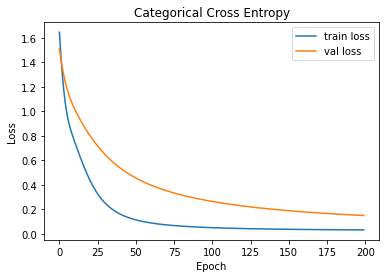

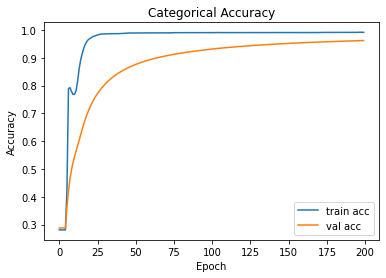

In [ ]:
plt.title("Categorical Cross Entropy")
plt.plot(range(len(tr_loss_bean)), tr_loss_bean, label='train loss')
plt.plot(range(len(v_loss_bean)), v_loss_bean, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.title("Categorical Accuracy")
plt.plot(range(len(tr_acc_bean)), tr_acc_bean, label='train acc')
plt.plot(range(len(v_acc_bean)), v_acc_bean, label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_pred = bean_model(X_tst_bean)
test_acc = (sum(categorical_accuracy(y_tst_bean, test_pred))/len(test_pred)).numpy()
test_loss = tensorflow.reduce_mean(categorical_crossentropy(y_tst_bean, test_pred)).numpy()

print('Final categorical cross-entropy:')
print('    train: '.ljust(12), round(tr_loss_bean[-1],3))
print('    test: '.ljust(12), round(test_loss,3))
print('    val: '.ljust(12), round(v_loss_bean[-1],3))

print('Final categorical accuracy:')
print('    train: '.ljust(12), round(tr_acc_bean[-1],3))
print('    test: '.ljust(12), round(test_acc,3))
print('    val: '.ljust(12), round(v_acc_bean[-1],3))

Final categorical cross-entropy:
    train:   0.033
    test:    0.037
    val:     0.151
Final categorical accuracy:
    train:   0.992
    test:    0.988
    val:     0.962


In [626]:
bean_model.save(os.path.join(ROOT_PATH, 'Assignment2_task1_model.h5'))
bean_model = tensorflow.keras.models.load_model(os.path.join(ROOT_PATH, 'Assignment2_task1_model.h5'))

# Question 2

### Note: 
#####Currently running into issues with incompatable matrix shapes during backpropagation that are preventing parts of code from compiling. Apart from that the overall logic should be correct.

In [ ]:
class Multiply():
    def forward(self,W,X):
        self.X = X
        self.W = W
        return np.matmul(self.W, self.X)
    def backward(self, upstream_g):
        X = self.X
        W = self.W
        dX = np.dot(upstream_g,W)
        dW = np.dot(upstream_g,X)
        return [dX, dW]

class Add():
    def forward(self,A,B):
        result = np.add(A, B)
        return result
    def backward(self, upstream_g):
        dA = upstream_g*1
        dB = upstream_g*1
        return [dA, dB]

class Sigmoid():
    def forward(self, M):
        self.Z = 1/(1 + np.exp(-M))
        return self.Z
    def backward(self, upstream_g):
        Z = self.Z
        local_g = Z*(1-Z)
        dZ = np.matmul(upstream_g, local_g)
        return dZ

class Softmax():
    def forward(self, M):
        self.Z = np.exp(M)/np.sum(np.exp(M))
        return self.Z
    def backward(self, upstream_g):
        Z = self.Z
        local_g = np.zeros_like(Z)
        for i in range(len(Z)):
            for j in range(len(Z)):
                indicator = 1 if i==j else 0
                local_g[i] = Z[i]*(indicator-Z[i]) 
        dM = np.dot(local_g,upstream_g)
        return dM

class CategoricalCrossEntropy():
    def forward(self, y, y_hat):
        self.y_hat = y_hat
        self.y = y
        L = np.zeros_like(y)
        for i in range(len(y)): # one-hot encoding -- labels represented as 2D matrix
            for j in range(len(y[i])):
                if y[i][j]==1:
                    L[i][j] = np.log(y_hat[i][j])
        return L
    def backward(self): #no upstream_gradient -- last step
        y_hat = self.y_hat
        y     = self.y
        dL = np.zeros_like(y)
        for i in range(len(y)):
            for j in range(len(y[i])):
                if y[i][j] ==1:
                    dL[i][j] = -y[i][j]/y_hat[i][j] + (1-y[i][j])/(1-y_hat[i][j])
        return dL

def OneHotAccuracy(y_hat, y):
    assert y_hat.shape == y.shape
    y_hat = np.argmax(y_hat,axis=1)
    y     = np.argmax(y,axis=1)
    agreed = sum([1 for i in range(len(y)) if y[i] == y_hat[i]])
    total = len(y)
    return agreed/total

def SGD(parameter, gradient, learning_rate, decay_factor):
    parameter = (parameter - learning_rate*gradient)*decay_factor
    return parameter

def split_into_batches(M, batch_size):
    start = 0
    batches = []
    while start < M.shape[0]:
        end = start + batch_size
        batch = M[start:end]
        batches.append(batch)
        start = end
    if len(M[start:]) > 0:
        batches.append(M[start:])
    return batches

In [ ]:
class Computation_Graph():
    def __init__(self): 

        # first layer
        self.mult_L1 = Multiply()
        self.add__L1 = Add()
        self.sig__L1 = Sigmoid()

        # second layer:
        self.mult_L2 = Multiply()
        self.add__L2 = Add()
        self.sig__L2 = Sigmoid()

        # third layer:
        self.mult_L3 = Multiply()
        self.add__L3 = Add()
        self.softmax = Softmax()

        # loss:
        self.loss   = CategoricalCrossEntropy()


    def forward(self,
                X, 
                Y,
                n_units_L1 = 8,
                n_units_L2 = 8,
                W_L1 = None,
                W_L2 = None,
                W_L3 = None):
        
        self.X = X
        self.Y = Y

        if W_L1 == None and W_L2 == None and W_L3 == None:
            W_L1 = np.random.rand(X.shape[1]+1, n_units_L1)*0.01
            W_L2 = np.random.rand(n_units_L1+1, n_units_L2)*0.01
            W_L3 = np.random.rand(n_units_L2+1, 3)*0.01

        W_L1 = self.W_L1 = W_L1[1:,:]
        b_L1 = self.b_L1 = W_L1[0,:]
        ####
        W_L2 = self.W_L2 = W_L2[1:,:]
        b_L2 = self.b_L2 = W_L2[0,:]
        ####
        W_L3 = self.W_L3 = W_L3[1:,:]
        b_L3 = self.b_L3 = W_L3[0,:]

        print('\n\n**Forward**\n\n')

        print('X.shape:        ',X.shape)
        print('Y.shape:        ',Y.shape,'\n')
        
        # layer 1
        print('\n*Layer 1*\n')
        XW1         = self.mult_L1.forward(X, W_L1)
        plus_b1     = self.add__L1.forward(XW1, b_L1)
        Z_1         = self.sig__L1.forward(plus_b1)
        print('W_L1.shape:     ',W_L1.shape)
        print('b_L1.shape:     ',b_L1.shape,'\n')
        print('XW1.shape:      ',XW1.shape)
        print('plus_b1.shape:  ',plus_b1.shape)
        print('Z_1.shape:      ',Z_1.shape)

        # layer 2
        print('\n*Layer 2*\n')
        W2Z1        = self.mult_L2.forward(Z_1, W_L2)
        plus_b2     = self.add__L2.forward(W2Z1, b_L2)
        Z_2         = self.sig__L2.forward(plus_b2)
        print('W_L2.shape:     ',W_L2.shape)
        print('b_L2.shape:     ',b_L2.shape,'\n')
        print('W2Z1.shape:     ',W2Z1.shape)
        print('plus_b2.shape:  ',plus_b2.shape)
        print('Z_2.shape:      ',Z_2.shape)

        # layer 3
        print('\n*Layer 3*\n')
        W3Z2        = self.mult_L3.forward(Z_2,W_L3)
        plus_b3     = self.add__L2.forward(W3Z2, b_L3) 
        self.Y_hat  = self.softmax.forward(W3Z2)
        print('W_L3.shape:     ',W_L3.shape)
        print('b_L3.shape:     ',b_L3.shape,'\n')
        print('W3Z2.shape:     ',W3Z2.shape)
        print('plus_b.shape:   ',plus_b3.shape)
        print('Y_hat.shape:    ',self.Y_hat.shape)

        # loss
        self.Loss = self.loss.forward(self.Y, self.Y_hat)
        print('Loss.shape:     ',self.Loss.shape)
        return self.Y_hat, self.Loss

    def backward(self):
        print('\n\n**Backward**\n\n')
        X     = self.X
        Y     = self.Y
        Y_hat = self.Y_hat
        W_L1  = self.W_L1
        W_L2  = self.W_L2
        W_L3  = self.W_L3

        # d_loss
        d_yhat = self.loss.backward()
        print('d_yhat.shape:       ', d_yhat.shape)

        # layer 3
        d_ZW3_plus_b   = self.softmax.backward(d_yhat)
        [d_ZW3, d_b3]  = self.add__L3.backward(d_ZW3_plus_b)
        [d_Z2,  d_W3]  = self.mult_L3.backward(d_ZW3)
        print('d_ZW3_plus_b.shape: ',self.d_Z3_plus_b.shape)
        print('d_W3.shape:         ',self.d_W3.shape)
        print('d_Z2.shape:         ',self.d_Z2.shape)

        # layer 2
        d_ZW2_plus_b   = self.sig__L2.backward(d_Z2)
        [d_ZW2, d_b2]  = self.add__L2.backward(d_ZW2_plus_b)
        [d_Z1,   d_W2] = self.mult_L2.backward(d_ZW2)
        print('d_ZW2_plus_b.shape: ',self.d_ZW2_plus_b.shape)
        print('d_W2.shape:         ',self.dW2.shape)
        print('d_Z1.shape:         ',self.d_Z1.shape)

        # layer 1
        d_ZW1_plus_b  = self.sig__L1.backward(d_Z1)
        [d_XW1, d_b1] = self.add__L1.backward(d_ZW1_plus_b)
        [d_X,   d_W1] = self.mult_L1.backward(d_XW1)
        print('d_ZW1_plus_b.shape: ',self.d_sig_Z1.shape)
        print('d_W1.shape:         ',self.d_W1.shape)
        print('d_X.shape:          ',self.d_X.shape)

        return d_W1, d_b1, d_W2, d_b2, d_W3, d_b3

    def train(self, X_train, y_train, lr, epochs, decay_factor, batch_size):
        train_losses = []
        train_accs = []

        X_batches = split_into_batches(X_train, batch_size)
        y_batches = split_into_batches(y_train, batch_size)

        for e in range(epochs):
            epoch_train_losses = []
            epoch_train_accs = []
            for (X_batch, y_batch) in zip(X_batches, y_batches):
                y_hat, train_loss = self.forward(X_batch, y_batch)
                train_loss  = tensorflow.reduce_mean(train_loss).numpy()
                train_acc   = OneHotAccuracy(y_batch, y_hat)
                epoch_train_losses.append(train_loss)
                epoch_train_accs.append(train_acc)

                d_W1, d_b1, d_W2, d_b2, d_W3, d_b3 = self.backward()
                self.W_L1 = SGD(self.W_L1, d_W1, lr, decay_factor)
                self.b_L1 = SGD(self.b_L1, d_b1, lr, decay_factor)
                self.W_L2 = SGD(self.W_L2, d_W2, lr, decay_factor)
                self.b_L2 = SGD(self.b_L2, d_b2, lr, decay_factor)
                self.W_L3 = SGD(self.W_L3, d_W3, lr, decay_factor)
                self.b_L3 = SGD(self.b_L3, d_W3, lr, decay_factor)
            epoch_train_loss = tensorflow.reduce_mean(epoch_train_losses).numpy()
            epoch_train_acc = tensorflow.reduce_mean(epoch_train_accs).numpy()
            train_losses.append(epoch_train_loss)
            train_accs.append(epoch_train_acc)

        return train_losses, train_accs

    def test(self, X_test, y_test):
        predictions, test_loss  = self.forward(X_test, y_test)
        test_acc = OneHotAccuracy(y_test, predictions)
        return test_loss, test_acc

In [ ]:
this_cg = Computation_Graph()
y_hat, loss = this_cg.forward(X_trn_wine, y_trn_wine)



**Forward**


X.shape:         (595, 11)
Y.shape:         (595, 3) 


*Layer 1*

W_L1.shape:      (11, 8)
b_L1.shape:      (8,) 

XW1.shape:       (595, 8)
plus_b1.shape:   (595, 8)
Z_1.shape:       (595, 8)

*Layer 2*

W_L2.shape:      (8, 8)
b_L2.shape:      (8,) 

W2Z1.shape:      (595, 8)
plus_b2.shape:   (595, 8)
Z_2.shape:       (595, 8)

*Layer 3*

W_L3.shape:      (8, 3)
b_L3.shape:      (3,) 

W3Z2.shape:      (595, 3)
plus_b.shape:    (595, 3)
Y_hat.shape:     (595, 3)
Loss.shape:      (595, 3)


In [ ]:
y_hat

array([[0.00056447, 0.0005568 , 0.00055941],
       [0.00056447, 0.0005568 , 0.00055941],
       [0.00056447, 0.0005568 , 0.00055941],
       ...,
       [0.00056447, 0.0005568 , 0.00055941],
       [0.00056447, 0.0005568 , 0.00055941],
       [0.00056447, 0.0005568 , 0.00055941]])

In [ ]:
loss

array([[ 0.        ,  0.        , -7.4886287 ],
       [ 0.        ,  0.        , -7.48863197],
       [ 0.        ,  0.        , -7.48863456],
       ...,
       [ 0.        ,  0.        , -7.48863404],
       [ 0.        ,  0.        , -7.48863364],
       [ 0.        ,  0.        , -7.48863467]])

There is clearly a problem -- the row values in y_hat are not summing to 1. There are a lot of matrix computations involved in this code and it's easy to make mistakes.

In [ ]:
y_hat, loss = this_cg.backward()



**Backward**


d_yhat.shape:        (595, 3)


ValueError: ignored

Another problem -- this time with matrix algebra. Again, a lot of computations involved in this task. Despite these issues, I think the overall logic of my work is correct.

Note -- because of these issues, this_cg.train() will produce errors, and this_cg.test() will produce innacurate results.

In [ ]:
y_hat_test, test_loss = this_cg.test(X_tst_wine, y_tst_wine)
print('\ny_hat_test:\n',y_hat_test)
print('\ntest_loss:\n',test_loss)



**Forward**


X.shape:         (149, 11)
Y.shape:         (149, 3) 


*Layer 1*

W_L1.shape:      (11, 8)
b_L1.shape:      (8,) 

XW1.shape:       (149, 8)
plus_b1.shape:   (149, 8)
Z_1.shape:       (149, 8)

*Layer 2*

W_L2.shape:      (8, 8)
b_L2.shape:      (8,) 

W2Z1.shape:      (149, 8)
plus_b2.shape:   (149, 8)
Z_2.shape:       (149, 8)

*Layer 3*

W_L3.shape:      (8, 3)
b_L3.shape:      (3,) 

W3Z2.shape:      (149, 3)
plus_b.shape:    (149, 3)
Y_hat.shape:     (149, 3)
Loss.shape:      (149, 3)

y_hat_test:
 [[ 0.          0.         -6.09808715]
 [ 0.          0.         -6.09808827]
 [ 0.         -6.10031433  0.        ]
 [ 0.         -6.10031691  0.        ]
 [ 0.          0.         -6.09808193]
 [ 0.          0.         -6.09808629]
 [ 0.          0.         -6.09808678]
 [ 0.          0.         -6.09808784]
 [ 0.          0.         -6.09808704]
 [ 0.          0.         -6.09808161]
 [ 0.          0.         -6.09808637]
 [ 0.         -6.10031354  0.        ]
 [ 0. 